(relay:viz)=
# 可视化 Relay 模块

Relay 模块可被可视化。

In [1]:
from tvm import relay
from tvm.ir import IRModule
from tvm.contrib.relay_viz import RelayVisualizer
from tvm.contrib.relay_viz.interface import (
    VizEdge,
    VizNode,
    VizParser
)

from tvm.contrib.relay_viz.dot import (
    DotPlotter,
    DotGraph,
    DotVizParser
)

定义简单的 `add` 模块：

In [2]:
x, y  = [relay.var(name) for name in "xy"]
add_op = x + y
main_func = relay.Function([x, y], add_op)
mod = IRModule()
mod["AddFunc"] = main_func
print(mod)

def @AddFunc(%x, %y) {
  add(%x, %y)
}



以语法树的形式查看：

In [3]:
viz = RelayVisualizer(mod)
viz.render()

@AddFunc([Var(x), Var(y)])
`--Call 
   |--add 
   |--Var(Input) name_hint: x
   `--Var(Input) name_hint: y


也可以导出到 PDF 文件：

In [4]:
viz = RelayVisualizer(mod, plotter=DotPlotter())
viz.render("add")

也可以直接在 Jupyter Notebook 展示：

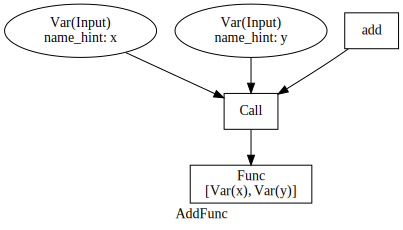

In [5]:
from graphviz import Digraph
from IPython.display import display_svg


class Visualizer(RelayVisualizer):
    def graph(self, graph_name):
        return self._plotter._name_to_graph[graph_name]

    def display(self, graph_name):
        graph = self.graph(graph_name)
        return graph.digraph

    def display_all(self, format="svg",
                    filename=None,
                    directory="images"):
        root_graph = Digraph(format=format,
                             filename=filename,
                             directory=directory)
        for graph in self._plotter._name_to_graph.values():
            root_graph.subgraph(graph.digraph)
        return root_graph


viz = Visualizer(mod, plotter=DotPlotter())
graph = viz.display("AddFunc")
display_svg(graph)

```{note}
`display_svg(graph)` 是为了兼容 Sphinx 而设，如果仅仅在 Jupyter Notebook 进行渲染，直接调用 `graph` 即可。
```

对可视化的结果添加色彩：

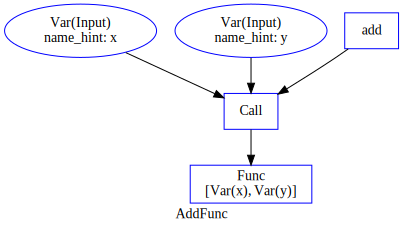

In [6]:
graph_attr = {"color": "red"}
node_attr = {"color": "blue"}
edge_attr = {"color": "black"}

# 添加颜色
dot_plotter = DotPlotter(
    graph_attr=graph_attr,
    node_attr=node_attr,
    edge_attr=edge_attr)

viz = Visualizer(mod, plotter=dot_plotter)
graph = viz.display("AddFunc")
display_svg(graph)

稍稍复杂点的“连加”算子：

In [7]:
mod = IRModule()

# 定义“加法”算子
data = relay.var("data")
bias = relay.var("bias")
add_op = data + bias
add_func = relay.Function([data, bias], add_op)
mod["AddFunc"] = add_func

In [8]:
add_gvar = mod.get_global_var("AddFunc")
x, y, z= [relay.var(name) for name in "xyz"]
add_01 = relay.Call(add_gvar, [x, y])
add_02 = relay.Call(add_gvar, [z, add_01])
main_func = relay.Function([x, y, z], add_02)
mod["main"] = main_func

仅仅查看 `main` 函数：

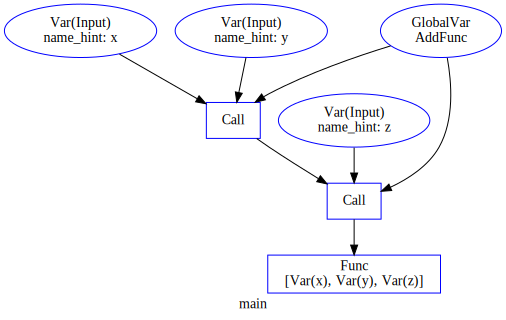

In [9]:
viz = Visualizer(mod, plotter=dot_plotter)
display_svg(viz.display("main"))

```{note}
从图中可以看出 `AddFunc` 函数被调用了两次。
```

查看全部函数：

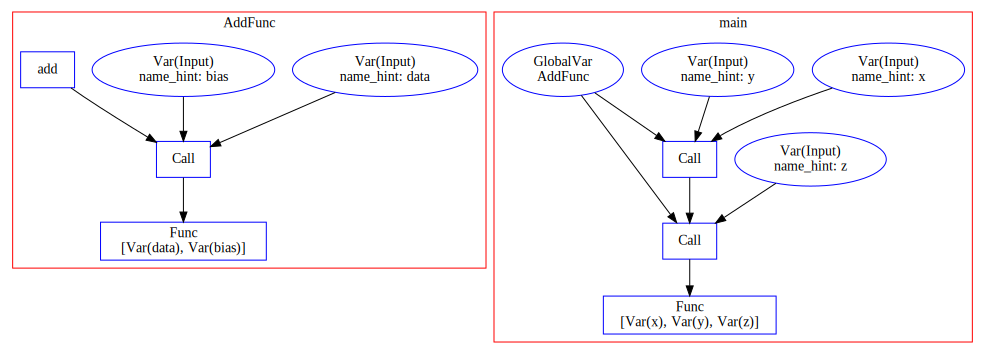

In [10]:
graph = viz.display_all("png")
display_svg(graph)

## 定制解析器

可以定制解析器：

In [11]:
from tvm.runtime.ndarray import NDArray


class YourAwesomeParser(VizParser):
    def __init__(self):
        self._delegate = DotVizParser()

    def get_node_edges(
        self,
        node: relay.Expr,
        relay_param: dict[str, NDArray],
        node_to_id: dict[relay.Expr, str],
    ) -> tuple[VizNode | None, list[VizEdge]]:

        if isinstance(node, relay.Var):
            node = VizNode(node_to_id[node], "AwesomeVar", f"name_hint {node.name_hint}")
            # no edge is introduced. So return an empty list.
            return node, []

        # delegate other types to the other parser.
        return self._delegate.get_node_edges(node, relay_param, node_to_id)

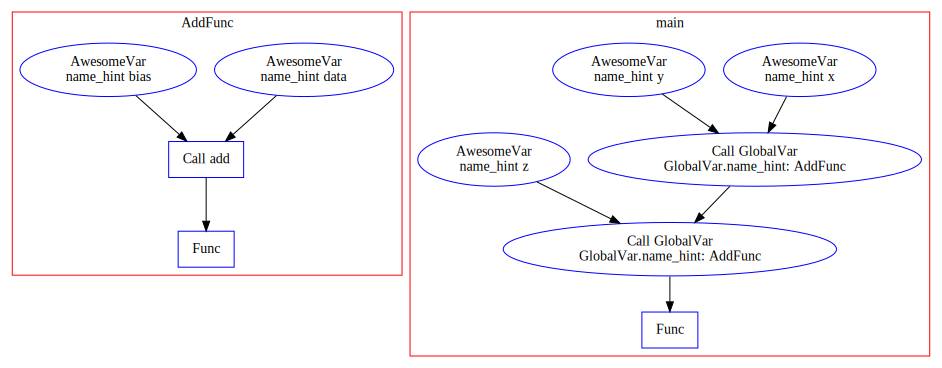

In [12]:
viz = Visualizer(mod,
                 plotter=dot_plotter,
                 parser=YourAwesomeParser())
graph = viz.display_all()
display_svg(graph)

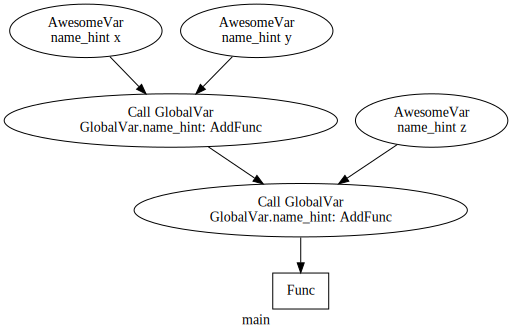

In [13]:
class AwesomeGraph(DotGraph):
    def node(self, viz_node):
        # add the node first
        super().node(viz_node)
        # if it's AwesomeVar, duplicate it.
        if viz_node.type_name == "AwesomeVar":
            duplicated_id = f"duplicated_{viz_node.identity}"
            duplicated_type = "double AwesomeVar"
            super().node(VizNode(duplicated_id, duplicated_type, ""))
            # connect the duplicated var to the original one
            super().edge(VizEdge(duplicated_id, viz_node.identity))


# override TermPlotter to use `AwesomeGraph` instead
class AwesomePlotter(DotPlotter):
    def create_graph(self, name):
        self._name_to_graph[name] = AwesomeGraph(name)
        return self._name_to_graph[name]



viz = Visualizer(mod,
                 plotter=DotPlotter(),
                 parser=YourAwesomeParser())
graph = viz.display("main")
display_svg(graph)

也可以用于可视化神经网络：

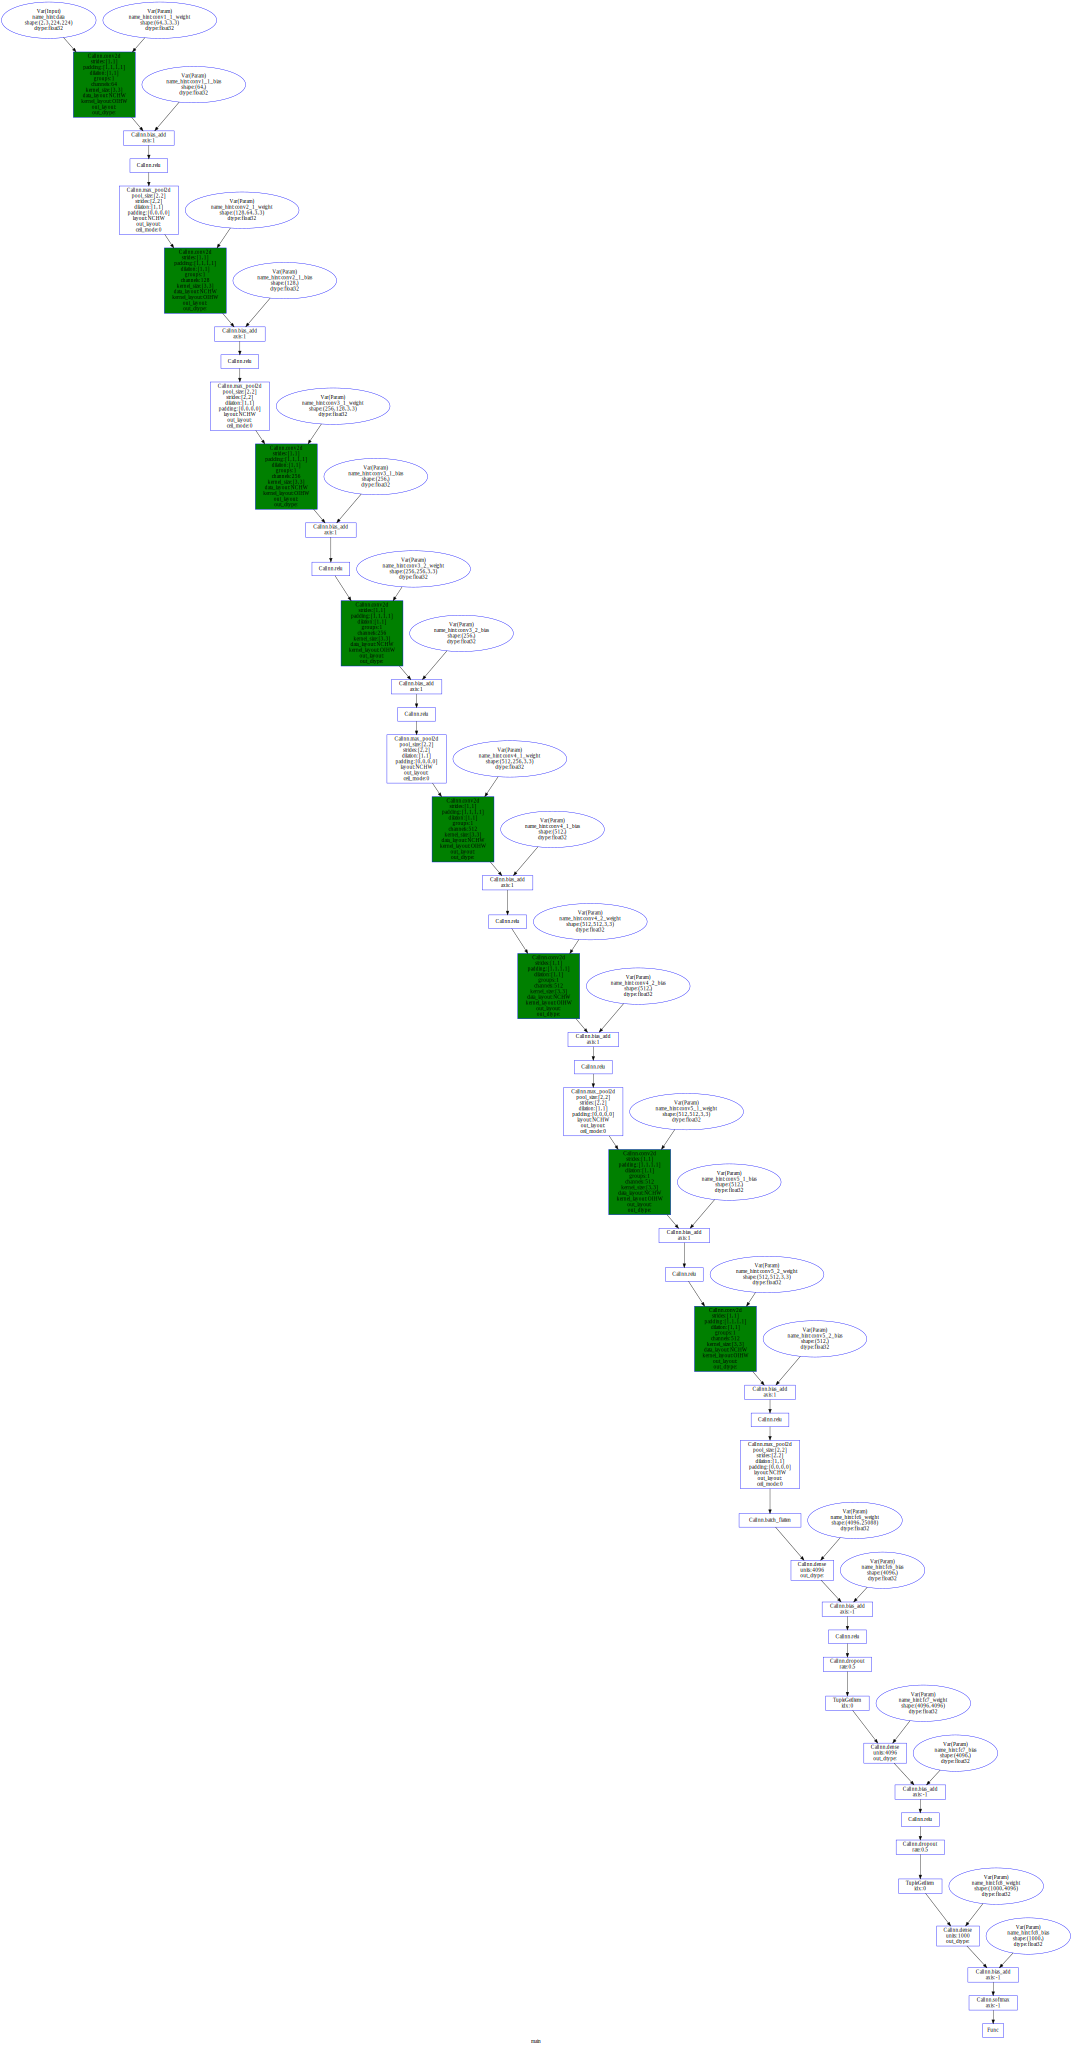

In [15]:
from tvm.relay.testing import vgg

mod, param = vgg.get_workload(batch_size=2,
                              num_layers=11)
# graphviz attributes
graph_attr = {"color": "red"}
node_attr = {"color": "blue"}
edge_attr = {"color": "black"}

# VizNode is passed to the callback.
# We want to color NCHW conv2d nodes. Also give Var a different shape.
def get_node_attr(node):
    if "nn.conv2d" in node.type_name and "NCHW" in node.detail:
        return {
            "fillcolor": "green",
            "style": "filled",
            "shape": "box",
        }
    if "Var" in node.type_name:
        return {"shape": "ellipse"}
    return {"shape": "box"}


# Create plotter and pass it to viz. Then render the graph.
dot_plotter = DotPlotter(
    graph_attr=graph_attr,
    node_attr=node_attr,
    edge_attr=edge_attr,
    get_node_attr=get_node_attr)

viz = Visualizer(
    mod,
    relay_param=param,
    plotter=dot_plotter,
    parser=DotVizParser())
graph = viz.display("main")
display_svg(graph)